# Forest-Guided Clustering Tutorial

This tutorial is an introduction on how to use the Forest-Guided Clustering python package to interpret your Random Forest model. We will show you:

1. how to install the Forest-Guided Clustering package
2. how to apply the Forest-Guided Clustering package to your trained Random Forest model
3. how to use the output visualizations for interpretation of your Random Forest model


Note: The Forest-Guided Clustering method provides insight into the structure of the data by identifying the features that guide the decision process of the Random Forest model. If the trained Random Forest model shows a poor performance, e.g. accuracy of 70% or lower, and therefore, makes poor decisions, the retrieved feature importance might not reflect the true underlying structures in the data.


## Installation

To use the Forest-Guided Clustering you have to install the fgclustering package first.

**Installation of the fgclustering package via PyPi:**

```pip install fgclustering```

**Installation of the fgclustering package via pip from source:**

Clone the git repo and install the downloaded package with:

```git clone https://github.com/HelmholtzAI-Consultants-Munich/fg-clustering.git```

```pip install .        (Installation as python package: run inside directory)```

or if you want to develop the package:

```pip install -e .        (Installation as python package: run inside directory)```

Note: if you are using conda, first install pip with: ```conda install pip```

## Data and Model Availability

To execute this tutorial you need the datasets and models for each example case. If you clone the git repo, you will find those in the ```data/``` folder. Alternatively, you can download the data folder via this [link](https://downgit.github.io/#/home?url=https://github.com/HelmholtzAI-Consultants-Munich/fg-clustering/blob/main/data).

## Import

In [1]:
## Import the Forest-Guided Clustering package
from fgclustering import FgClustering

## Additional imports for use-cases
import joblib
import pandas as pd

## Example for Forest-Guided Clustering on binary-classification Random Forest model

The first use-case is a simple binary classification Random Forest model. The Random Forest classifier is trained based on the Breast Cancer dataset from ```sklearn.datasets``` (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)). This dataset contains 569 samples of 212 malignant (class 0) and 357 benign (class 1) tumors. The tumors are described by 30 numeric features computed from a digitized image taken of breast mass. We trained a Random Forest Classifier on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_samples```. The Out-of-Bag accuracy of the tuned prediction model is 96%. 

In [2]:
data_breast_cancer = pd.read_csv('./data/data_breast_cancer.csv')
rf = joblib.load(open('./data/random_forest_breat_cancer.joblib', 'rb'))

To understand, which features play an important role for the classification of tumors into malignant and benign, we apply the Forest-Guided Clustering method. We use the loaded pre-processed breast cancer dataset and trained Random Forest Classifier as input for the instantiation of the ```FgClustering``` class. Furthermore, we have to indicate, which column of the dataset contains the target values (```target_column``` parameter, this parameter can also be the vector of target values, which then should not be a part of the dataset). Optional parameters are:

- ```random_state```: Seed number for random state, defaults to 42


In [3]:
fgc = FgClustering(model=rf, data=data_breast_cancer, target_column='target')

Interpreting RandomForestClassifier


To run the Forest-Guided Clustering method we have to execute the ```run``` function. This function has several optional parameters:

- ```number_of_clusters```: Number of clusters for the k-medoids clustering. Leave None if number of clusters should be optimized, defaults to None
- ```max_K```: Maximum number of clusters for cluster score computation, defaults to 8
- ```bootstraps_JI```: Number of bootstraps to compute the Jaccard Index, defaults to 300
- ```max_iter_clustering```: Number of iterations for k-medoids clustering, defaults to 500
- ```discart_value_JI```: Minimum Jaccard Index for cluster stability, defaults to 0.6 


If the parameter ```number_of_clusters``` is not specified, the ```run``` function will compute the optimal number of clusters, based on a scoring function that consideres the class mixture of the cluster, the so-called *score* and the cluster stability, the so-called *Jaccard Index*. The lower the *score* the better the seperation of target values between cluster (e.g. classes that are well mixed within single clusters imply a high score, while having only one class within each cluster would lead to a low score). The lower the *Jaccard Index* the lower the cluster stability, e.g. if we repeat the clustering on a subsample of the original dataset we will get a very different clustering. The *Jaccard Index* returns values between 0 (unstable) and 1 (stable), where 0.6 is suggested as a good cutoff for stability, i.e. clusterings with a *Jaccard Index* > 0.6 are considered as stable (see [Read the Docs documentation](https://forest-guided-clustering.readthedocs.io/en/latest/general_algorithm.html#general-algorithm) for further explanations). 

After optimizing the number of clusters, the k-Medoids clustering algorithm is applied to the distance matrix (which is computed from the Random Forest proximity matrix) where k is the optimal number of clusters. 

In [4]:
fgc.run()

 17%|█▋        | 1/6 [00:24<02:00, 24.05s/it]

For number of cluster 2 the Jaccard Index is 0.9929533726112989
For number of cluster 2 the score is 0.06075601429195926


 33%|███▎      | 2/6 [01:06<02:20, 35.14s/it]

For number of cluster 3 the Jaccard Index is 0.951932482648236
For number of cluster 3 the score is 0.16715848101924288


 50%|█████     | 3/6 [02:43<03:10, 63.40s/it]

For number of cluster 4 the Jaccard Index is 0.7423235155870698
For number of cluster 4 the score is 0.11800660882985625


 67%|██████▋   | 4/6 [05:25<03:24, 102.09s/it]

For number of cluster 5 the Jaccard Index is 0.7140331272667625
For number of cluster 5 the score is 0.0937287660151763


 83%|████████▎ | 5/6 [09:01<02:23, 143.29s/it]

For number of cluster 6 the Jaccard Index is 0.7054073217896802
For number of cluster 6 the score is 0.0898883258202708


100%|██████████| 6/6 [13:25<00:00, 134.29s/it]

For number of cluster 7 the Jaccard Index is 0.2615056293251512
Clustering is instable, no score computed!
The optimal number of clusters is 2
Optimal number of cluster is: 2


The optimal number of clusters in for the breast cancer dataset is *k=2*. We can see from the output above that *k=2* leads to the lowest *score* of 0.06 while having a *Jaccard Index* of 0.99, which means that the clustering is almost perfectly stable. Clusterings with k between 3 and 6 have stable clustering as well but higher scores, and hence, the seperation of target values between clusters is less god, e.g. higher class-mixture within a cluster. The clustering with 7 clusters has a *Jaccard Index* < 0.6 and hence is defined unstable and not considered for the choice of the optimal k. 

In a second step, we use the significance of the difference between cluster-wise feature distributions as a measure of global feature importance (ANOVA for continuous features and chi square for categorical features). Features, which have significantly different distributions across clusters, have a high feature importance, while features, which have a similar feature distribution across clusters have a low feature importance. Those features are considered to be less important in the decision making process of the Random Forest model (see description [here](https://forest-guided-clustering.readthedocs.io/en/latest/feature_importance.html#global-feature-importance) for further explanations).

To plot the global feature importance, we run the ```plot_global_feature_importance``` function. The resulting plots can be saved by setting the ```save``` parameter.

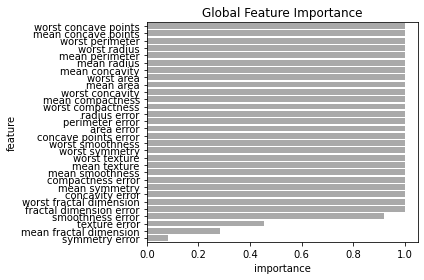

In [5]:
fgc.plot_global_feature_importance()

In addition to the global feature importance, we also provide a local feature importance, which gives the importance of each feature for each cluster. For the local feature importance we pre-filter the features based on the global feature importance (```thr_pvalue``` is used for this filtering step). Here, a feature is considered important if its distribution in a particlular cluster is clearly different from the feature distribution in the whole dataset. E.g. if the feature values in a certain cluster would be spread over the whole feature range, the feature would not be considered important for the interpretation of the clusters because it does not show any trend or pattern that differentiates the clusters and hence, we would not be able to draw any clear conclusions from it (see description [here](https://forest-guided-clustering.readthedocs.io/en/latest/feature_importance.html#local-feature-importance) for further explanations).

To plot the local feature importance, we run the ```plot_local_feature_importance``` function. The resulting plots can be saved by setting the ```save``` parameter. Optional parameters are:

- ```bootstraps_p_value```: Number of bootstraps to compute the p-value of feature importance, defaults to 1000
- ```thr_pvalue```: P-value threshold for global feature importance filtering, defaults to 0.01

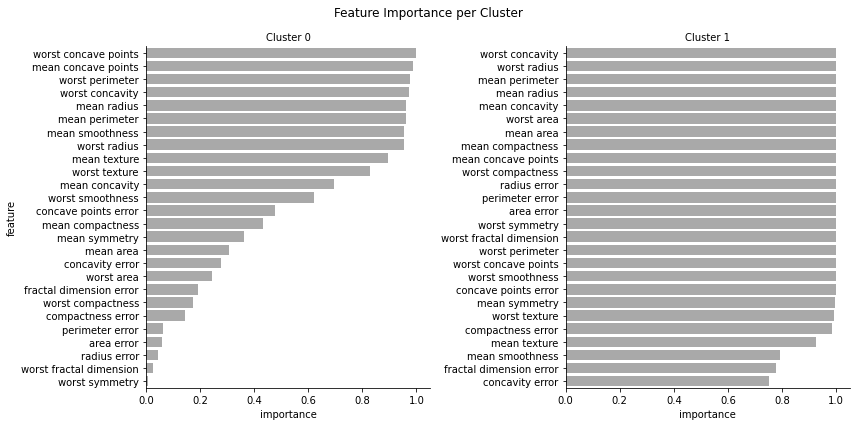

In [6]:
fgc.plot_local_feature_importance()

The heatmap provides a general overview on the target value attribution and feature enrichment / depletion per cluster.  We can see which classes/target values fall into which cluster and samples that fall into the "wrong" cluster can be inspected further as they might be extreme outliers or wrongly labelled samples / measurement errors.

To plot the heatmap, we run the ```plot_heatmap``` function. The resulting plots can be saved by setting the ```save``` parameter. Optional parameters are:

- ```thr_pvalue```: P-value threshold for global feature importance filtering, defaults to 0.01

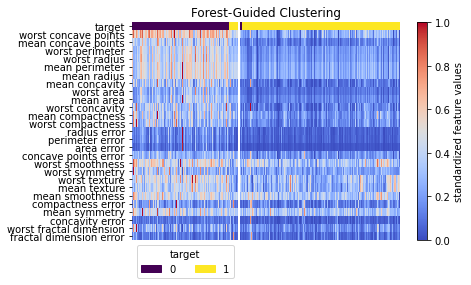

In [7]:
fgc.plot_heatmap()

The boxplots contain the same information as the heatmap just presented in a different way. Here the features are not standardized and we can see the actual scale of each feature on the y axis. Furthermore, we get an idea of the distribution of feature values within each cluster, e.g. having a small or high within-cluster-variation. 

To plot the heatmap, we run the ```plot_boxplots``` function. The resulting plots can be saved by setting the ```save``` parameter. Optional parameters are:

- ```thr_pvalue```: P-value threshold for global feature importance filtering, defaults to 0.01

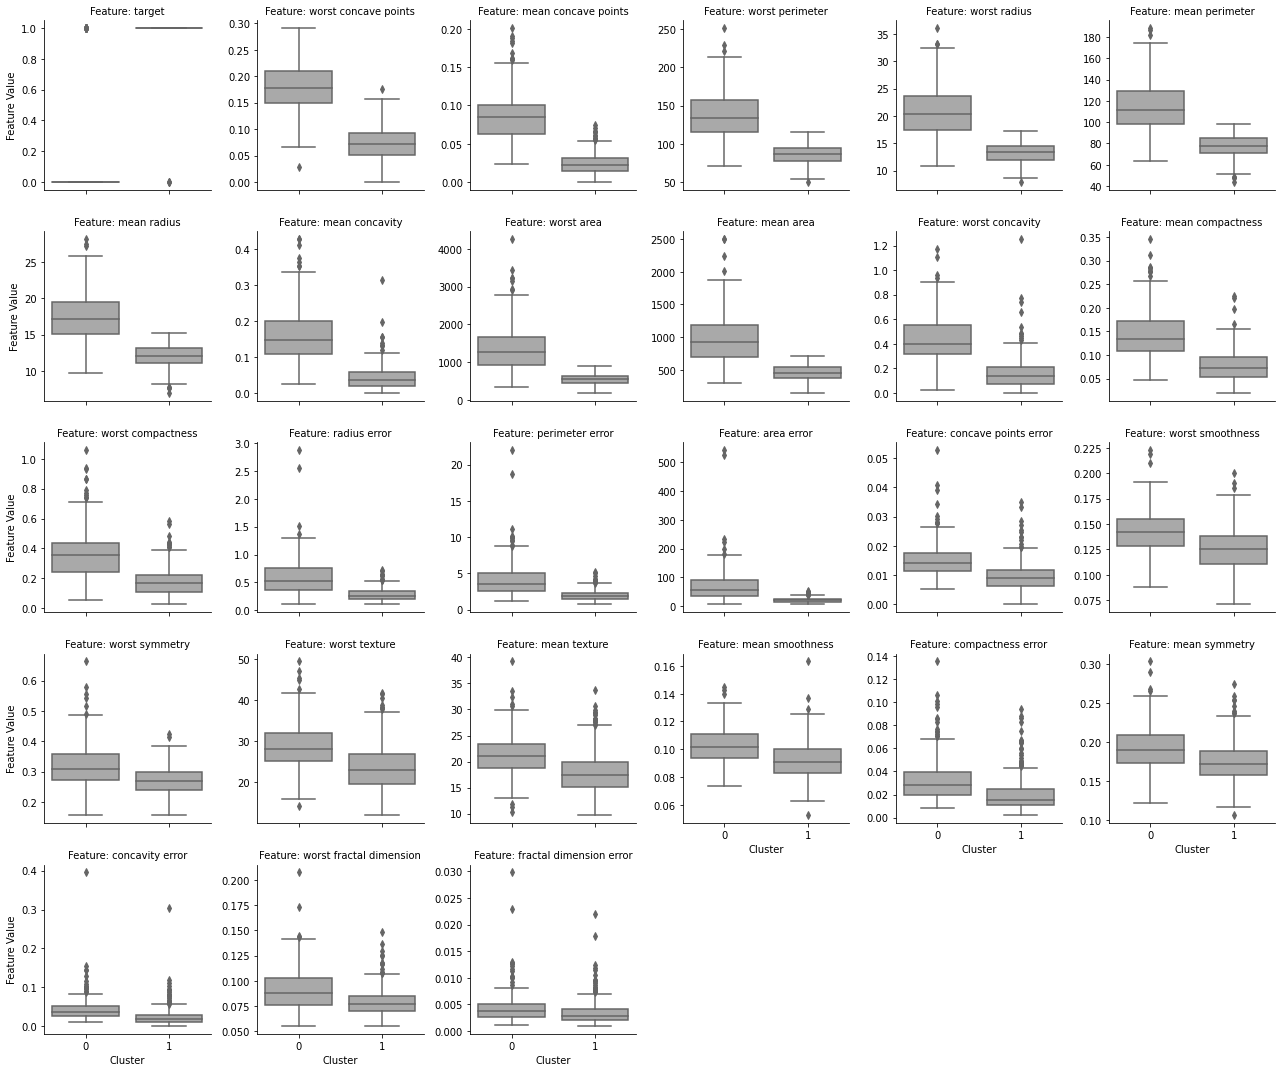

In [8]:
fgc.plot_boxplots()

From the resulting plots we can draw the following conclusions for malignent and benign tumors:

- the two classes are almost perfectly attributed to the two clusters. Only a few samples fall into the "wrong" cluster, which could be further inspected to rule out labelling errors
- the top ranked features in the boxplots and feature importance show the biggest difference of feature values between cluster
- cluster 0 samples, have higher values for all important features than cluster 1 samples, i.e. malignent tumors have more worst concave points, a higher compactness and a larger radius and perimeter

## Example for Forest-Guided Clustering on multiclass-classificiation Random Forest model

The second use-case illustrates how Forest-Guided Clustering can be used to interpret a multi-class classificiation model. The Random Forest classifier is trained based on the Iris dataset from ```sklearn.datasets``` (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset)). This dataset contains 150 samples, of each class 50 (Iris-Setosa, Iris-Versicolour, Iris-Virginica). The plants are described by 4 plant specific characteristics, encoded in numeric features. We trained a Random Forest Classifier on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_samples```. The Out-of-Bag accuracy of the tuned prediction model is 94%. 

In [9]:
data_iris = pd.read_csv('./data/data_iris.csv')
rf = joblib.load(open('./data/random_forest_iris.joblib', 'rb'))

To understand, which plant characteristics play an important role for the classification of the different Iris species, we apply the Forest-Guided Clustering method. We use the loaded pre-processed iris dataset and trained Random Forest Classifier as input for the ```FgClustering``` class and execute the ```run``` function. For further description of the input parameters see binary classification example above.

In [11]:
fgc = FgClustering(model=rf, data=data_iris, target_column='target')
fgc.run()

Interpreting RandomForestClassifier


 17%|█▋        | 1/6 [00:00<00:02,  1.88it/s]

For number of cluster 2 the Jaccard Index is 0.9977572463768115
For number of cluster 2 the score is 0.25


 33%|███▎      | 2/6 [00:01<00:03,  1.23it/s]

For number of cluster 3 the Jaccard Index is 0.9880392065141461
For number of cluster 3 the score is 0.0841213837498657


 50%|█████     | 3/6 [00:02<00:02,  1.15it/s]

For number of cluster 4 the Jaccard Index is 0.7601604936457884
For number of cluster 4 the score is 0.1438279988151725


 67%|██████▋   | 4/6 [00:03<00:02,  1.03s/it]

For number of cluster 5 the Jaccard Index is 0.45483802308802296
Clustering is instable, no score computed!


 83%|████████▎ | 5/6 [00:05<00:01,  1.11s/it]

For number of cluster 6 the Jaccard Index is 0.5979444166944166
Clustering is instable, no score computed!


100%|██████████| 6/6 [00:06<00:00,  1.08s/it]

For number of cluster 7 the Jaccard Index is 0.6722142857142857
For number of cluster 7 the score is 0.14609653385163587
The optimal number of clusters is 3
Optimal number of cluster is: 3


We can see from the output above that the optimal number of clusters is *k=3*, which leads to the lowest *score* while having a stable clustering.

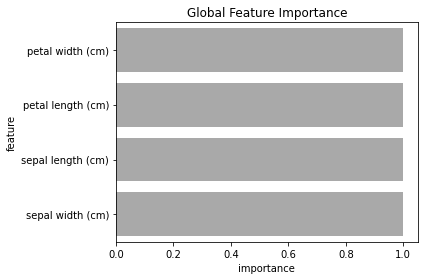

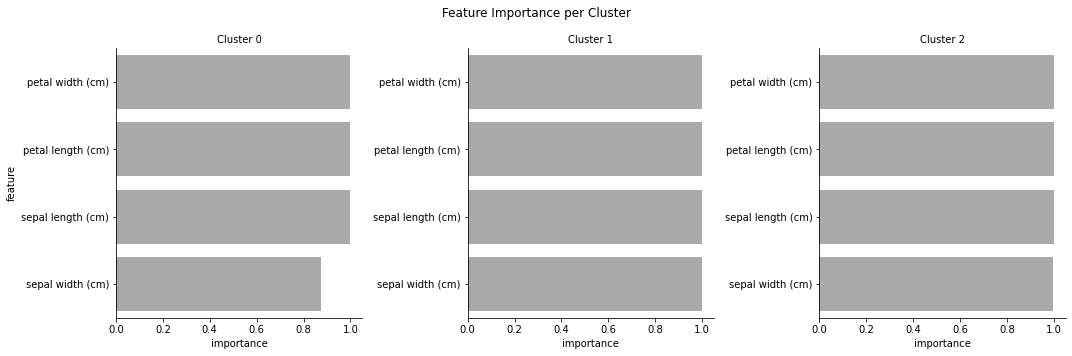

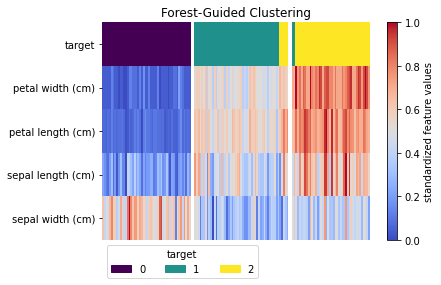

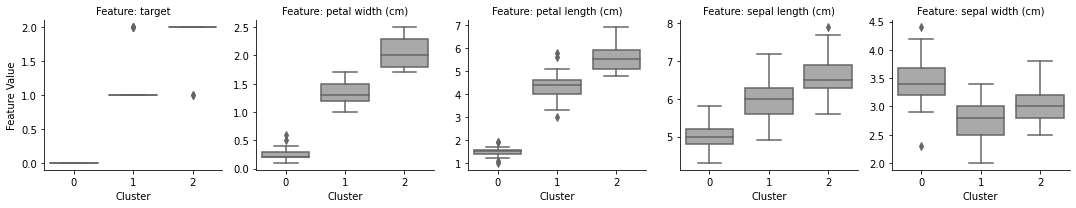

In [12]:
fgc.plot_global_feature_importance()
fgc.plot_local_feature_importance()
fgc.plot_heatmap()
fgc.plot_boxplots()

From the resulting plots we can draw the following conclusions:

- the three classes are almost perfectly attributed to the three clusters. Only a few samples of class 1 and 2 fall into the "wrong" cluster, which could be further inspected
- all features are important for the clustering and show a clear trend within each cluster
- cluster 0, which contains only class 0 samples, is described by small petal width and length as well as sepal length but large sepal width
- cluster 1, which mainly contains only class 1 samples, shows the opposite pattern than cluster 0
- cluster 2, which contains only class 2 samples, is described by small sepal width but intermediate values for petal width and length as well as sepal length

## Example for Forest-Guided Clustering on regression Random Forest model
The third use-case illustrates how Forest-Guided Clustering can be used to interpret a regression model. The Random Forest Regressor is trained on the Boston Housing dataset from ```sklearn.datasets``` (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-house-prices-dataset)). This dataset contains 506 house prices, which are described by 12 numeric and one categorical feature. We trained a Random Forest Regressor on the whole dataset and tuned the hyperparameters via 5 fold cross-validation, where we optimized the parameters: ```max_depth``` and ```max_samples```. The Out-of-Bag MSE of the tuned prediction model is 0.57. 

In [13]:
data_boston = pd.read_csv('./data/data_boston.csv')
data_boston['CHAS'] = data_boston['CHAS'].astype('category')
rf = joblib.load(open('./data/random_forest_boston.joblib', 'rb'))

To understand the relation between housing prices and the provided features (e.g. tax, crime rate etc.), we apply the Forest-Guided Clustering method. We use the loaded pre-processed boston housing dataset and trained Random Forest Regressor as input for the ```FgClustering``` class and execute the ```run``` function. For further description of the input parameters see binary classification example above.

In [15]:
fgc = FgClustering(model=rf, data=data_boston, target_column='target')
fgc.run()

Interpreting RandomForestRegressor


 17%|█▋        | 1/6 [01:40<08:23, 100.68s/it]

For number of cluster 2 the Jaccard Index is 0.954680142996491
For number of cluster 2 the score is 33046.55399114103


 33%|███▎      | 2/6 [05:31<11:48, 177.10s/it]

For number of cluster 3 the Jaccard Index is 0.8973068388144109
For number of cluster 3 the score is 25348.227436875182


 50%|█████     | 3/6 [11:21<12:48, 256.08s/it]

For number of cluster 4 the Jaccard Index is 0.5923495386707318
Clustering is instable, no score computed!


 67%|██████▋   | 4/6 [19:50<11:51, 355.83s/it]

For number of cluster 5 the Jaccard Index is 0.7724615105095125
For number of cluster 5 the score is 15154.844851017115


 83%|████████▎ | 5/6 [27:54<06:42, 402.19s/it]

For number of cluster 6 the Jaccard Index is 0.5509388401478257
Clustering is instable, no score computed!


100%|██████████| 6/6 [36:13<00:00, 362.20s/it]

For number of cluster 7 the Jaccard Index is 0.43393722736112067
Clustering is instable, no score computed!
The optimal number of clusters is 5
Optimal number of cluster is: 5


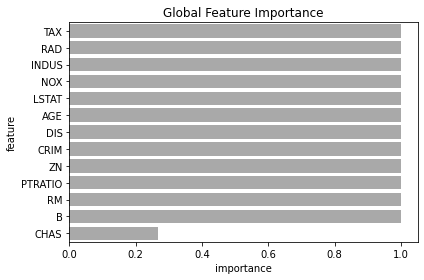

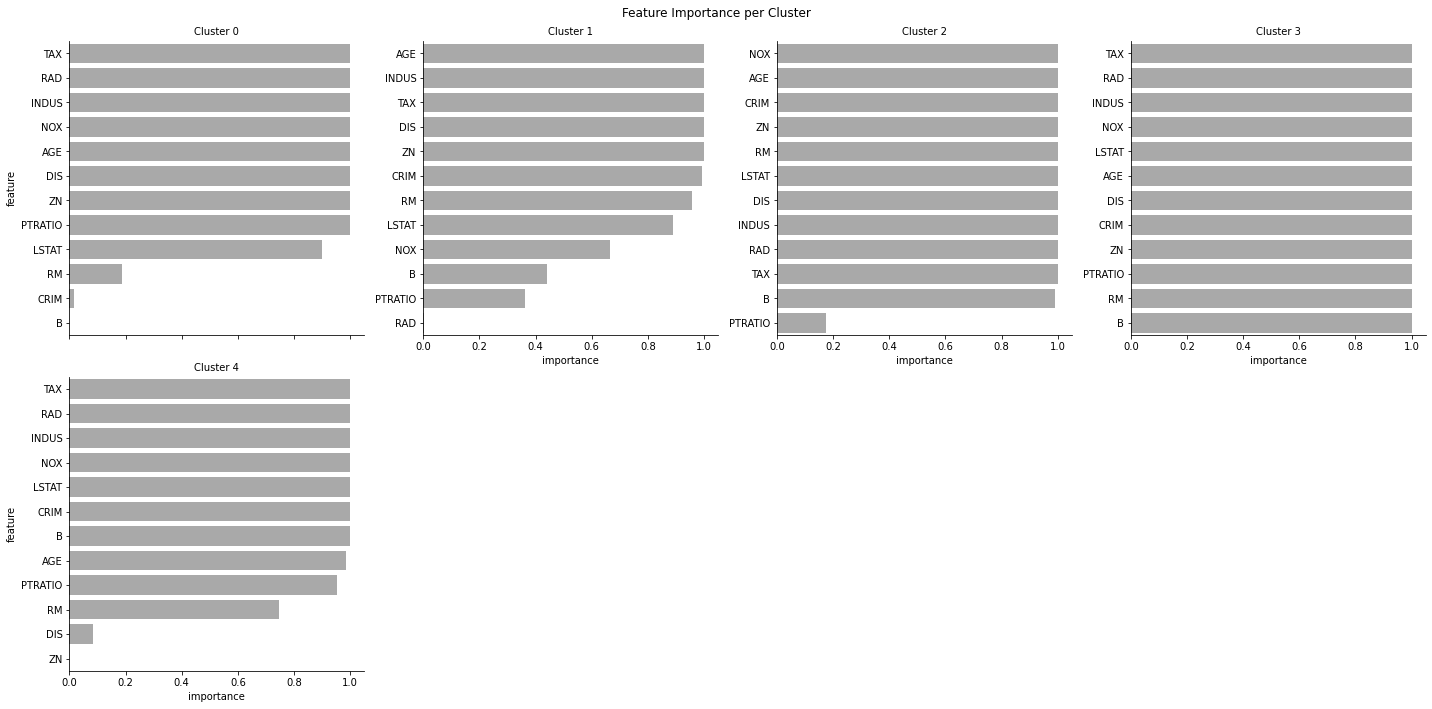

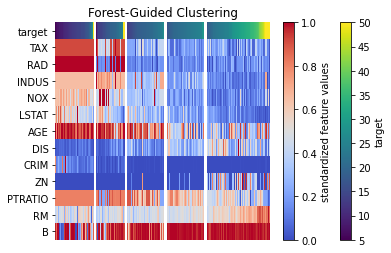

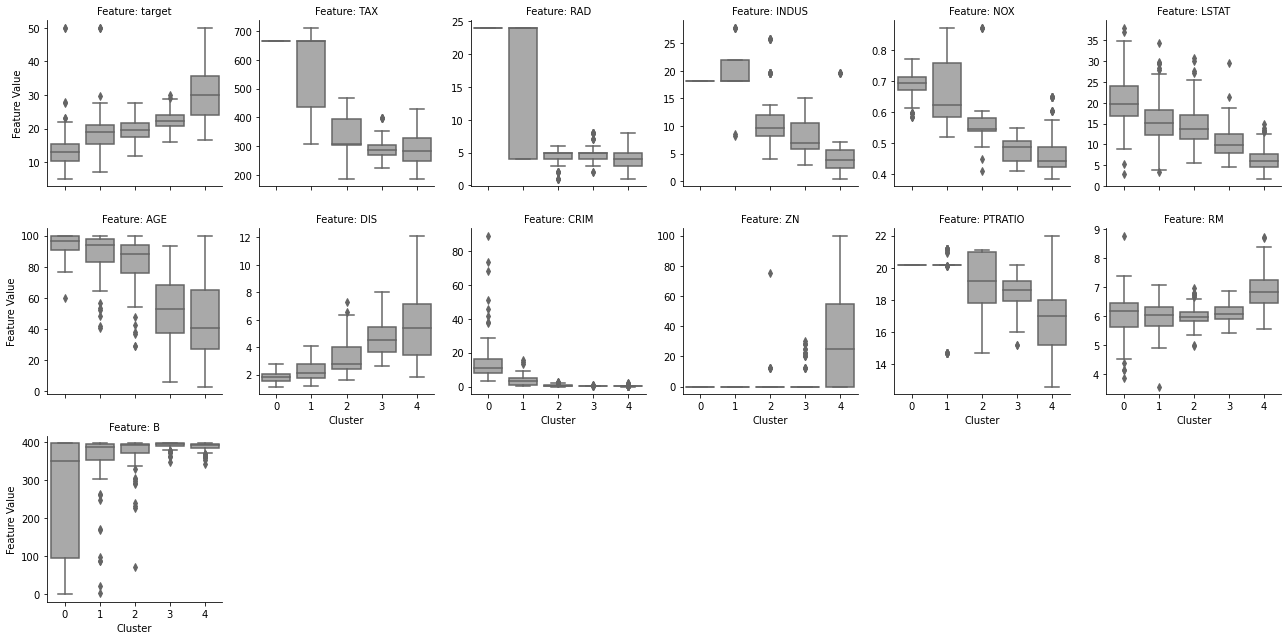

In [17]:
fgc.plot_global_feature_importance()
fgc.plot_local_feature_importance()
fgc.plot_heatmap()
fgc.plot_boxplots()

From the resulting plots we can draw the following conclusions:

- cluster 0 and cluster 4 contain the lowest and highest housing prices, respectively. Clusters 1 to 3 contain intermediate housing prices
- lowly priced houses are in areas with high crime rate (CRIM) and high nitric oxides concentration (NOX), located close to employment centers (DIS), have a high tax rate (TAX) and are mostly build before 1940 (AGE)
- highly priced houses are in areas with low crime rate (CRIM) and low nitric oxides concentration (NOX), located further away from employment centers (DIS), have a low tax rate (TAX) and are mostly build after 1940 (AGE)
- feature B, RAD and ZN have a low feature importance for cluster 0, 1 and 4, respectively because there is no clear trend in the feature values for the specific cluster, e.g. we cannot say that the feature is enriched or depleted in that cluster. Instead the feature values cover almost the full range of possible values and therefore, no clear conclusion can be drawn about the feature trend within that cluster
